<div style="background-color:#000;"><img src="pqn.png"></img></div><div><a href="https://pyquantnews.com/">PyQuant News</a> is where finance practitioners level up with Python for quant finance, algorithmic trading, and market data analysis. Looking to get started? Check out the fastest growing, top-selling course to <a href="https://www.pyquantnews.com/getting-started-with-python-for-quant-finance/">get started with Python for quant finance</a>. For educational purposes. Not investment advice. Use at your own risk.</div>

## Library installation

Install the third-party libraries used in this notebook so you can download market data and run the risk parity optimizer locally.

In [ ]:
!pip install yfinance riskfolio-lib

Riskfolio-Lib depends on scientific Python packages (like NumPy, pandas, SciPy, and CVXPy) that pip will usually pull in automatically, but some environments need compilers or platform-specific wheels. If installation fails, try a fresh conda environment or follow the Riskfolio-Lib docs for your OS.

## Imports and setup

We use warnings to silence noisy library output, yfinance to fetch historical prices from Yahoo Finance, and riskfolio (Riskfolio-Lib) to estimate covariances and solve the risk parity optimization.

In [1]:
import warnings

In [2]:
import riskfolio as rp
import yfinance as yf

In [3]:
warnings.filterwarnings("ignore")

Filtering warnings keeps the notebook output readable while we iterate on portfolio sizing ideas, but it can also hide useful diagnostics during troubleshooting. If you run into unexpected results, consider removing this line so you can see numerical and data warnings.

## Build a clean returns matrix

Define the investable universe, fetch adjusted close data with yfinance, and convert prices into daily returns that the risk model can work with.

In [4]:
assets = [
    "JCI",
    "TGT",
    "CMCSA",
    "CPB",
    "MO",
    "APA",
    "MMC",
    "JPM",
    "ZION",
    "PSA",
    "BAX",
    "BMY",
    "LUV",
    "PCAR",
    "TXT",
    "TMO",
    "DE",
    "MSFT",
    "HPQ",
    "SEE",
    "VZ",
    "CNP",
    "NI",
    "T",
    "BA",
]

In [5]:
assets.sort()

In [8]:
data = yf.download(assets, start="2016-01-01", end="2024-12-31")

[*********************100%***********************]  25 of 25 completed


In [9]:
closes = data.Close
returns = closes.pct_change().dropna()

Risk parity is only as good as the returns matrix we feed it, so getting aligned daily returns is the real “data engineering” step here. Using pct_change() gives simple (non-log) returns, which is a common choice for covariance-based risk models at daily frequency.

## Estimate risk model inputs

Create a Riskfolio-Lib Portfolio object and estimate expected returns and the covariance matrix from historical data.

In [10]:
port = rp.Portfolio(returns=returns)

In [12]:
port.assets_stats(method_mu="hist", method_cov="hist")

This is where we separate “signals” from “sizing”: even with no alpha model, we still need a defensible covariance estimate to understand concentration. Using method_cov="hist" keeps the example simple, but in real workflows you’d compare alternatives (EWMA, shrinkage) because covariance estimation drives risk contributions.

## Solve risk parity weights

Optimize for risk parity weights using historical scenarios, then re-run with a minimum return constraint to show the tradeoff between return targeting and equal risk contribution.

In [13]:
w_rp = port.rp_optimization(
    model="Classic",
    rm="MV",
    hist=True,
    rf=0,
    b=None,
)

In [14]:
port.lowerret = 0.0008

In [15]:
w_rp_c = port.rp_optimization(
    model="Classic",
    rm="MV",
    hist=True,
    rf=0,
    b=None,
)

The unconstrained solution is the “pure sizing layer” that tries to keep one volatile stock from silently dominating portfolio swings. Adding port.lowerret forces the optimizer to chase a minimum expected return, which typically breaks perfect equality in risk contributions, and that’s exactly the point: we can measure the compromise instead of guessing.

## Visualize weights and risk contributions

Plot weights and risk contributions for both portfolios so we validate diversification in risk terms rather than trusting the weight vector.

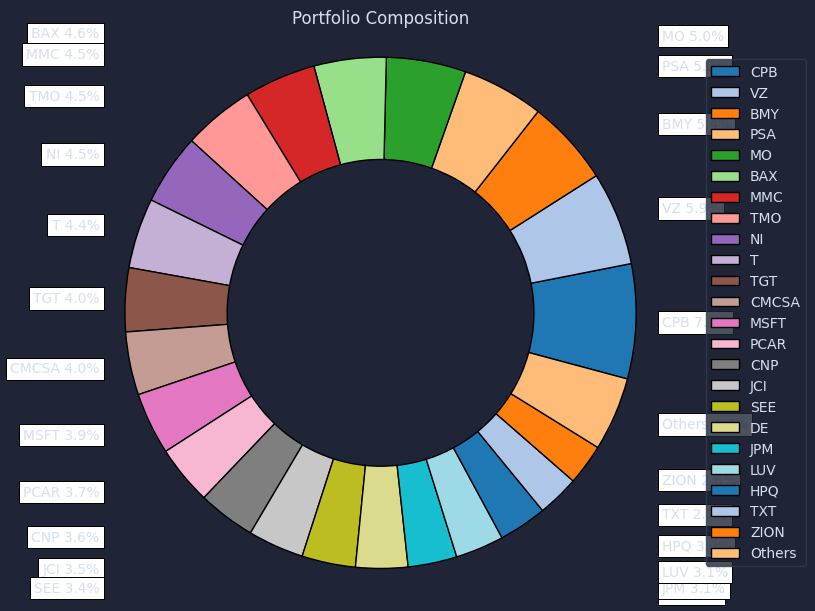

In [16]:
ax = rp.plot_pie(w=w_rp)

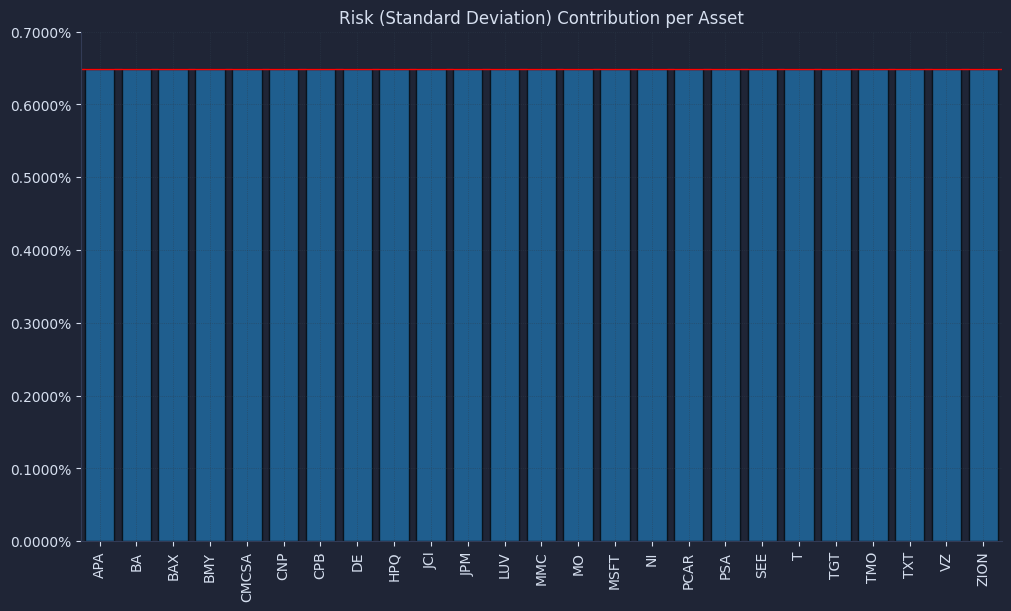

In [17]:
ax = rp.plot_risk_con(
    w_rp,
    cov=port.cov,
    returns=port.returns,
    rm="MV",
    rf=0,
)

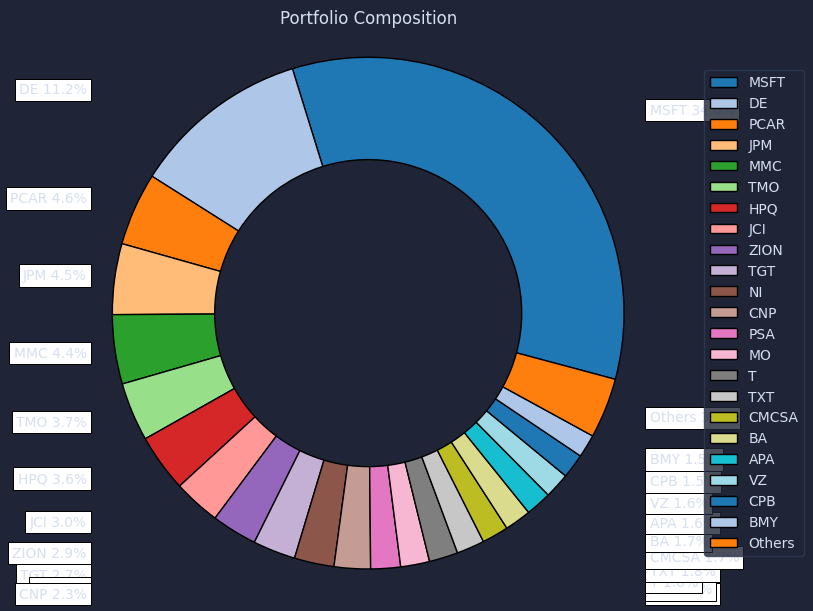

In [18]:
ax = rp.plot_pie(w=w_rp_c)

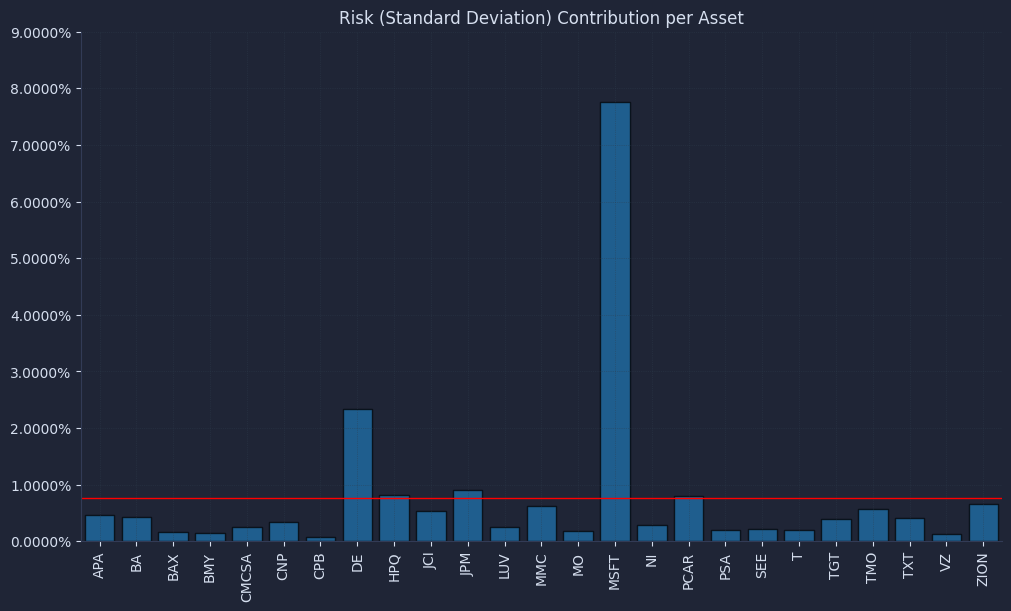

In [19]:
ax = rp.plot_risk_con(
    w_rp_c,
    cov=port.cov,
    returns=port.returns,
    rm="MV",
    rf=0,
)

The pie charts can look “diversified” in both cases, but the risk contribution plot is the professional check that answers the real question: who is driving our PnL variance. This validation step is what helps us stop confusing “many tickers” with “many independent bets,” especially once constraints start pushing the optimizer away from equal risk.

<a href="https://pyquantnews.com/">PyQuant News</a> is where finance practitioners level up with Python for quant finance, algorithmic trading, and market data analysis. Looking to get started? Check out the fastest growing, top-selling course to <a href="https://www.pyquantnews.com/getting-started-with-python-for-quant-finance/">get started with Python for quant finance</a>. For educational purposes. Not investment advice. Use at your own risk.